In [4]:
#VISUALIZACION DE INTERPRETACION
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from groundedPL.logic_tester import LogicTester
from itertools import product, combinations
import random
lt = LogicTester()

NUM_FILAS = 8
NUM_COLUMNAS = 8

def visualizar(I):
        # Inicializo el plano que contiene la figura
        fig, axes = plt.subplots()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)

        step = 1/NUM_FILAS
        tangulos = []
        font_size = step * 100
        colors = dict()
        colors[1] = (0,0,1)
        colors[2] = (0,0.5,0)
        colors[3] = (1,0,0)
        colors[4] = (0,0,0.5)
        colors[5] = (0.5,0,0)
        colors[6] = (0,0.5,0.5)
        colors[7] = (0,0,0)
        colors[8] = (0.5,0.5,0.5)

        # Creo los cuadrados claros en el tablero
        for atomo in I:
            if I[atomo]:
                # DECODIFICAMOS EL ÁTOMO PARA VISUALIZACIÓN
                predicado = lt.to_lp.obtener_predicado(atomo)
                x, y, n = lt.to_lp.obtener_argumentos(atomo)
                x = int(x)
                old_y = y
                y = NUM_COLUMNAS - int(y) - 1
                n = int(n)

                if predicado == 'ELECCION':
                    # tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='green'))
                    plt.text(x * step + step / 2,
                             y * step + step / 2,
                             f'E',
                             fontsize=font_size,
                             color='green')
                if predicado == 'TAPADA':
                    tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='lightslategrey'))
                elif predicado == 'MINA' and not I[lt.to_lp.parse(f'TAPADA({x},{old_y})')]:
                    tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='red'))
                elif predicado == 'NUM' and n > 0 and not I[lt.to_lp.parse(f'TAPADA({x},{old_y})')]:
                    plt.text(x * step + step / 2,
                             y * step + step / 2,
                             f'{n}',
                             fontsize=font_size,
                             color=colors[n])

        # Creo las líneas del tablero
        for j in range(8):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, step + locacion), 1, 0.005],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(step + locacion, 0), 0.005, 1],\
                    facecolor='black'))
        # Dibujo el tablero
        for t in tangulos:
            axes.add_patch(t)
        plt.show()

In [5]:
#CONVERTIR MODELO EN DICCIONARIO
def to_dict(literales: list[str]):
    I = dict()
    for literal in literales:
        if literal[0] == '-':
            I[literal[1:]] = False
        else:
            I[literal] = True
    return I

In [ ]:
#GENERACION DE TABLERO Y REGLAS
casillas = [(x,y) for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)]
nums = range(9)

for x, y in product(range(NUM_FILAS), range(NUM_COLUMNAS)):
    formula = f'MINA({x},{y})'
    lt.to_lp.parse(formula)
    formula = f'TAPADA({x},{y})'
    lt.to_lp.parse(formula)
    formula = f'ELECCION({x},{y})'
    lt.to_lp.parse(formula)
    for n in nums:
        formula = f'NUM({x},{y},{n})'
        lt.to_lp.parse(formula)


def vecinos(pos: tuple[int,int]):
    vecinos = [(x,y) for x in range(pos[0] - 1, pos[0] + 2) for y in range(pos[1] - 1, pos[1] + 2)]
    vecinos = [casilla for casilla in vecinos if casilla != pos and 0 <= casilla[0] < NUM_FILAS and 0 <= casilla[1] < NUM_COLUMNAS]
    return vecinos

def Ytoria(forms: list[str]) -> str:
    if len(forms) == 0:
        return None
    if type(forms) == str:
        return forms
    ytoria = ''
    if len(forms) > 0:
        for i in range(len(forms)):
            if(0 < i < len(forms)):
                ytoria += '&'
            if(
                '&' in forms or
                '|' in forms or
                '->' in forms 
            ):
                ytoria += '(' + forms[i] + ')'
            else:
                ytoria +=  forms[i] 
    return ytoria

def YtoriaForms(forms: list[str]) -> str:
    if len(forms) == 0:
        return None
    if type(forms) == str:
        return forms
    # ytoria = '('
    ytoria = ''
    if len(forms) > 0:
        for i in range(len(forms)):
            if(0 < i < len(forms)):
                ytoria += '∧'
            if(
                '&' in forms or
                '|' in forms or
                '->' in forms 
            ):
                ytoria += '(' + forms[i] + ')'
            else:
                ytoria +=  forms[i] 
        # ytoria += ')'
    return ytoria

def Otoria(forms: list[str]) -> str:
    if len(forms) == 0:
        return None
    if type(forms) == str:
        return forms
    otoria = ''
    if len(forms) > 0:
        for i in range(len(forms)):
            if(0 < i < len(forms)):
                otoria += '|'
            if(
                '&' in forms or
                '|' in forms or
                '->' in forms 
            ):
                otoria += '(' + forms[i] + ')'
            else:
                otoria +=  forms[i] 
    return otoria

#Regla 1: Cuando una casilla no tiene una mina, tiene un numero.
def regla_1():
    formulas = []
    for casilla in casillas:
        formulas_otoria = []
        for num in nums:
            formula = f'NUM({casilla[0]},{casilla[1]},{num})'
            formulas_otoria.append(formula)
        otoria = Otoria(formulas_otoria)
        a = f'-MINA({casilla[0]},{casilla[1]})->({otoria})'
        b = f'({otoria})->-MINA({casilla[0]},{casilla[1]})'
        formula = f'({a})&({b})'
        formulas.append(formula)
    return Ytoria(formulas)
        
#Regla 2: Una casilla debe contener un solo numero
def regla_2():
    formulas_ytoria = []
    formulas = []
    for casilla in casillas:
        x = casilla[0]
        y = casilla[1]
        for n in nums:
            formulas_ytoria = []
            for m in nums:
                if n != m:
                    formula = f'-NUM({x},{y},{m})'
                    formulas_ytoria.append(formula)
            ytoria = Ytoria(formulas_ytoria)
            formula = f'NUM({x},{y},{n}) -> ({ytoria})'
            formulas.append(formula)
    return Ytoria(formulas)

            
#Regla 3: El numero de una casilla coincide con la cantidad de sus vecinos que contengan una mina.
def regla_3():
    formulas_ytoria = []
    for casilla in casillas:
        vec = vecinos(casilla)
        for num in nums:
            if(num > len(vec)):
                continue
            combinaciones = list(combinations(vec, num))
            formulas_otoria = []
            for S in combinaciones:
                ytoria_minas = []
                ytoria_vacia = []
                for mina in S:
                    formula = f'MINA({mina[0]},{mina[1]})'
                    ytoria_minas.append(formula)
                for vacia in vec:
                    if vacia not in S:
                        formula = f'-MINA({vacia[0]},{vacia[1]})'
                        ytoria_vacia.append(formula)
                minas = Ytoria(ytoria_minas)
                vacias = Ytoria(ytoria_vacia)
                if(vacias == None):
                    formula = minas
                elif(minas == None):
                    formula = vacias
                else:
                    formula = f'{minas} & {vacias}'
                formulas_otoria.append(formula)
            otoria = Otoria(formulas_otoria)
            a = f'( NUM({casilla[0]},{casilla[1]},{num}) -> ({otoria}) )'
            b = f'( ({otoria}) -> NUM({casilla[0]},{casilla[1]},{num}) )'
            formula = f'{a} & {b}'
            formulas_ytoria.append(formula)
    return Ytoria(formulas_ytoria)

#Regla 4: Si una casilla es una mina, debe estar tapada. (De modo que no acabe el juego)
def regla_4():
    formulas = []
    for casilla in casillas:
        formula = f'MINA({casilla[0]},{casilla[1]}) -> TAPADA({casilla[0]}, {casilla[1]})'
        formulas.append(formula)
    return Ytoria(formulas)

#------------Reglas de elección de casilla----------

#Regla 5: Una casilla (x,y) es seleccionable si y solo si no contiene una mina
def regla_5():
    formulas = []
    for casilla in casillas:
        a = f'ELECCION({casilla[0]},{casilla[1]})'
        b = f'-MINA({casilla[0]},{casilla[1]})'
        formula = f'({a}->{b})&({b}->{a})'
        formulas.append(formula)
    return Ytoria(formulas)


#Regla 6:  Si una casilla destapada (x,y) contiene al numero n, y se tienen n vecinos marcados inseleccionables 
#(es decir, se dedujo que tienen una mina), el resto de vecinos tapados no son minas.
def regla_6():
    formulas_ytoria = []
    for casilla in casillas:
        vec = vecinos(casilla)
        for num in nums:
            if num > len(vec):
                continue
            combinaciones = list(combinations(vec, num))
            for S in combinaciones:
                if num == len(vec):
                    continue
                #izquierda
                formula = f'( NUM({casilla[0]},{casilla[1]},{num}) & -TAPADA({casilla[0]},{casilla[1]})'
                minas = []
                for mina in S:
                    minas.append(f'MINA({mina[0]},{mina[1]})')
                if len(minas) > 0:
                    formula += '&' + Ytoria(minas) 
                formula += ') -> '
                #derecha
                vacias = []
                for vecino in vec:
                    if vecino not in S:
                        vacias.append(f'-MINA({vecino[0]},{vecino[1]})')

                formula += '(' + Ytoria(vacias) + ')'
                formulas_ytoria.append(formula)
    return Ytoria(formulas_ytoria)


#Regla 7: Si una casilla destapada (x,y) contiene al numero n, y se tienen n vecinos tapados, entonces los vecinos tapados son minas.
def regla_7():
    formulas_ytoria = []
    for casilla in casillas:
        vec = vecinos(casilla)
        for num in nums:
            if num > len(vec):
                continue
            combinaciones = list(combinations(vec, num))
            for S in combinaciones:
                if num == 0:
                    continue
                formula = f'( NUM({casilla[0]},{casilla[1]},{num}) & -TAPADA({casilla[0]},{casilla[1]})'
                tapados = []
                minas = []
                for vecino in vec:
                    if vecino in S:
                        tapados.append(f'TAPADA({vecino[0]},{vecino[1]})')
                        minas.append(f'MINA({vecino[0]},{vecino[1]})')
                    else:
                        tapados.append(f'-TAPADA({vecino[0]},{vecino[1]})')

                if len(tapados) > 0:
                    formula += f' & {Ytoria(tapados)}'

                formula += f') -> ({Ytoria(minas)})'
                formulas_ytoria.append(formula)
    return Ytoria(formulas_ytoria)

minas = [(3,4),(3,2),(5,2),(7,1)]

def regla_tablero():
    literales = []
    tablero = []
    for _ in range(NUM_FILAS):
        fila = []
        for _ in range(NUM_COLUMNAS):
            fila.append(0)
        tablero.append(fila)

    for mina in minas:
        tablero[mina[1]][mina[0]] = '*'

        for vecino in vecinos(mina):
            if type(tablero[vecino[1]][vecino[0]]) == int:
                tablero[vecino[1]][vecino[0]] += 1


    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            if tablero[y][x] != '*':
                num = tablero[y][x]
                if random.randint(0,10) < 9:
                    literales.append(f'TAPADA({x},{y})')
                    tablero[y][x] = '-'
                else:
                    literales.append(f'-TAPADA({x},{y})')
                    literales.append(f'-MINA({x},{y})')
                literales.append(f'NUM({x},{y},{num})')
            else:
                literales.append(f'TAPADA({x},{y})')
    

    for fila in tablero:
        for casilla in fila:
            print(f'{str(casilla)}', end=', ')
        print('\n')
    return Ytoria(literales)

def reglas():
    r = []
    print('reglaTablero')
    r.append(regla_tablero())
    print('regla1')
    r.append(regla_1())
    # print('regla2')
    # r.append(regla_2())
    # print('regla3')
    # r.append(regla_3())
    # print('regla4')
    # r.append(regla_4())
    # print('regla5')
    # r.append(regla_5())
    # print('regla6')
    # r.append(regla_6())
    # print('regla7')
    # r.append(regla_7())
    print('reglas listas.')
    return Ytoria(r)

def reglas_individual():
    r = []
    print('reglaTablero')
    r.append(lt.translation_to_prover(regla_tablero()))
    # print('regla1')
    # r.append(lt.translation_to_prover(regla_1()))
    # print('regla2')
    # r.append(lt.translation_to_prover(regla_2()))
    # print('regla3')
    # r.append(lt.translation_to_prover(regla_3()))
    # print('regla4')
    # r.append(lt.translation_to_prover(regla_4()))
    # print('regla5')
    # r.append(lt.translation_to_prover(regla_5()))
    # print('regla6')
    # r.append(lt.translation_to_prover(regla_6()))
    # print('regla7')
    # r.append(lt.translation_to_prover(regla_7()))
    # print('reglas listas.')
    return YtoriaForms(r)

reglaTablero
-, -, -, -, 0, -, -, -, 

-, -, 1, -, -, -, -, *, 

-, 0, -, *, -, *, -, 1, 

-, -, 2, -, 3, -, -, -, 

-, -, -, *, -, -, -, -, 

-, 0, -, -, -, -, -, -, 

-, -, -, 0, -, -, -, -, 

-, -, -, -, -, 0, -, -, 

solucionando...
La fórmula es satisfacible


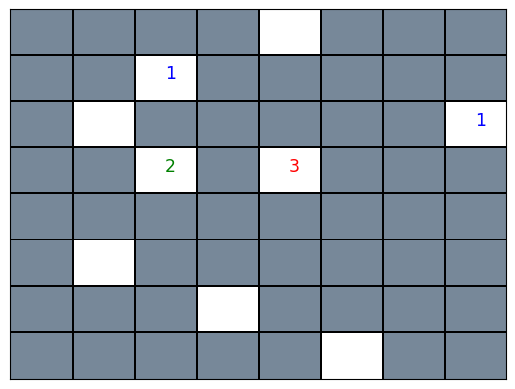

In [48]:
#SOLUCION DEL PROBLEMA
# formula_lp = lt.translation_to_prover(reglas())
formula_lp = reglas_individual()
print('solucionando...')
res = lt.SATsolve(formula_lp)
modelo = []
if res == 'UNSAT':
    print('La fórmula es insatisfacible')
else:
    print('La fórmula es satisfacible')
    modelo = [lt.to_numeric.literal(x) for x in res]
    modelo = [x for x in modelo if lt.to_numeric.solo_atomo(x) in lt.tseitin.atomos] 
    # print(f'\nUn modelo es:\n\n\t{modelo}')
    # decodificado = [lt.to_lp.modelo_lp.decodificar(x) for x in modelo]
    # print(f'\nEl modelo decodificado es:\n\n\t{decodificado}')
    I = to_dict(modelo)
    visualizar(I)